**타이타닉 우주선이 우주를 비행하다가 침몰 ... 승객이 튀어져 나가버렷는데 찾으러 가야하는 문제임.**

데이터 필드
- **PassengerID**: gggg_pp 승객 탑승아이디 출발 그룹으루 분류
- **HomePlanet**: 출발 지 행성 
- **CroySleep**: 냉동상태로 이동 여부  (????? 수면마취급인가? 뭐지???)
- **Cabin**: 승객이 객실 위치 Deck(아직 뭘 의미하는지 모름)/Num/Side(Side P or S 좌현 우현)\
- **Destination**: 목적지 승객이 내릴 장소
- **Age**
- **VIP**
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: 부가서비스 추가금액(우주선 좋은데?)
- **Name**: 이게 아무런 상관관계가 없어보이지만.. 낚시당할수도 있어 분석해야해
- **Transported**: 예측필드 승객이 튕겨나가 버렸는지 여부

In [138]:
# 우주타이타닉 문제
import pandas as pd

train_df = pd.read_csv('data/train.csv')
print(train_df.head())
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  


In [140]:
# 생존 비율 분석하깅
transport_df = train_df[train_df['Transported'] == False]

# 부익부 빈익빈?
print(f"VIP 생존 비율: {len(transport_df[transport_df['VIP'] == True]) / len(train_df[train_df['VIP']==True])}")
print("VIP과 Transported의 상관계수:", train_df[['VIP', 'Transported']].dropna().corr().iloc[0, 1])
print('\n-------------------------------------------------------------\n')

print(f"냉동수면 생존 비율: {len(transport_df[transport_df['CryoSleep'] == True]) / len(train_df[train_df['CryoSleep']==True])}")
print("CryoSleep과 Transported의 상관계수:", train_df[['CryoSleep', 'Transported']].dropna().corr().iloc[0, 1])

print('\n-------------------------------------------------------------\n')

# 종족 우선주의..
print(f"Mars 출신 생존 비율: {len(transport_df[transport_df['HomePlanet'] == 'Mars']) / len(train_df[train_df['HomePlanet']=='Mars'])}")
train_df['IsMars'] = (train_df['HomePlanet'] == 'Mars').astype(int)  # Mars면 1, 아니면 0
correlation = train_df[['IsMars', 'Transported']].dropna().corr().iloc[0, 1]
print(f"Mars 출신 여부와 Transported의 상관계수: {correlation:.3f}") 
print(f"Earth 출신 생존 비율: {len(transport_df[transport_df['HomePlanet'] == 'Earth']) / len(train_df[train_df['HomePlanet']=='Earth'])}")
print(f"Europa 출신 생존 비율: {len(transport_df[transport_df['HomePlanet'] == 'Europa']) / len(train_df[train_df['HomePlanet']=='Europa'])}")

print('\n-------------------------------------------------------------\n')

# 목적지 비율
print(f"PSO J318.5-22행 생존 비율: {len(transport_df[transport_df['Destination'] == 'PSO J318.5-22']) / len(train_df[train_df['Destination']=='PSO J318.5-22'])}")
print(f"55 Cancri e행 생존 비율: {len(transport_df[transport_df['Destination'] == '55 Cancri e']) / len(train_df[train_df['Destination']=='55 Cancri e'])}")
print(f"TRAPPIST-1e행 생존 비율: {len(transport_df[transport_df['Destination'] == 'TRAPPIST-1e']) / len(train_df[train_df['Destination']=='TRAPPIST-1e'])}")

print('\n-------------------------------------------------------------\n')
print(f"A Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'A']) / len(train_df[train_df['Deck']=='A'])}")
print(f"B Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'B']) / len(train_df[train_df['Deck']=='B'])}")
print(f"C Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'C']) / len(train_df[train_df['Deck']=='C'])}")
print(f"D Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'D']) / len(train_df[train_df['Deck']=='D'])}")
print(f"E Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'E']) / len(train_df[train_df['Deck']=='E'])}")
print(f"F Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'F']) / len(train_df[train_df['Deck']=='F'])}")
print(f"G Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'G']) / len(train_df[train_df['Deck']=='G'])}")
print(f"T Deck사용 생존 비율: {len(transport_df[transport_df['Deck'] == 'T']) / len(train_df[train_df['Deck']=='T'])}")
train_df['IsT'] = (train_df['Deck'] == 'T').astype(int)  # Mars면 1, 아니면 0
correlation = train_df[['IsT', 'Transported']].dropna().corr().iloc[0, 1]
print(f"T Deck사용 여부와 Transported의 상관계수: {correlation:.3f}") 

print('\n-------------------------------------------------------------\n')

print(f"S Side 사용 생존 비율: {len(transport_df[transport_df['Side'] == 'S']) / len(train_df[train_df['Side']=='S'])}")
print(f"P Side 사용 생존 비율: {len(transport_df[transport_df['Side'] == 'P']) / len(train_df[train_df['Side']=='P'])}")

VIP 생존 비율: 0.6180904522613065
VIP과 Transported의 상관계수: -0.03764972225919799

-------------------------------------------------------------

냉동수면 생존 비율: 0.18241685874217978
CryoSleep과 Transported의 상관계수: 0.46864486081240314

-------------------------------------------------------------

Mars 출신 생존 비율: 0.4769755542922115
Mars 출신 여부와 Transported의 상관계수: 0.020
Earth 출신 생존 비율: 0.5760538896132117
Europa 출신 생존 비율: 0.34115438761145

-------------------------------------------------------------

PSO J318.5-22행 생존 비율: 0.4962311557788945
55 Cancri e행 생존 비율: 0.39
TRAPPIST-1e행 생존 비율: 0.5288250211327135

-------------------------------------------------------------

A Deck사용 생존 비율: 0.50390625
B Deck사용 생존 비율: 0.26572528883183566
C Deck사용 생존 비율: 0.31994645247657294
D Deck사용 생존 비율: 0.5669456066945606
E Deck사용 생존 비율: 0.6426940639269406
F Deck사용 생존 비율: 0.5601288475304224
G Deck사용 생존 비율: 0.4837827276279797
T Deck사용 생존 비율: 0.8
T Deck사용 여부와 Transported의 상관계수: -0.015

-------------------------------------------

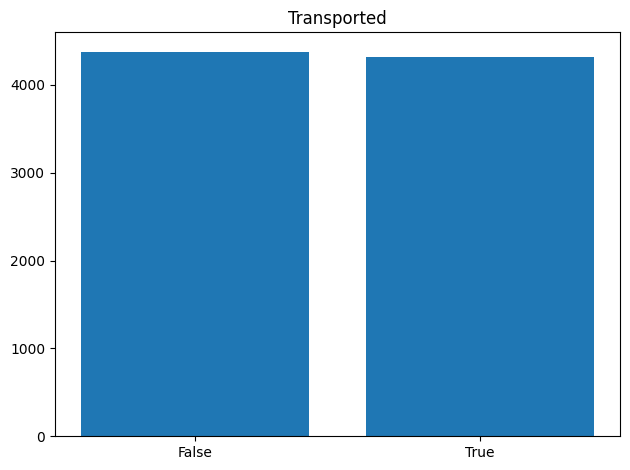

In [85]:
# 데이터 분석!
import matplotlib.pyplot as plt

transport_df = train_df[train_df['Transported'] == False]
# 생존자 비율~
fig, ax = plt.subplots(1, 1)
ax.set_title("Transported")
ax.bar(['False', 'True'], train_df['Transported'].value_counts())

plt.tight_layout()
plt.show()


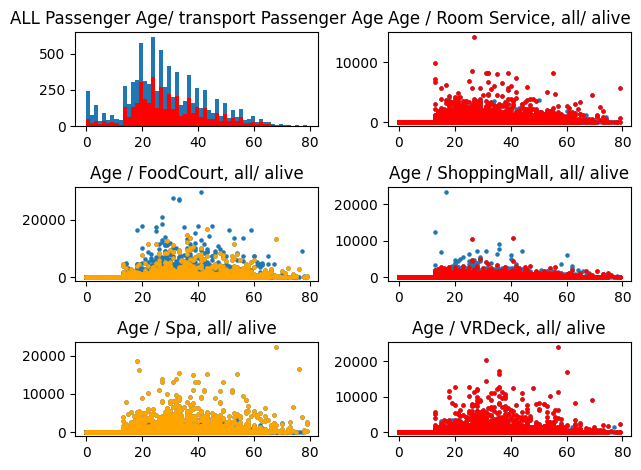

In [86]:
# 나이 상관관계 분석
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['Age'], bins=55, label='ALL Passenger Age')
ax[0][0].set_title("ALL Passenger Age/ transport Passenger Age")
ax[0][0].hist(transport_df['Age'], bins=55, color='red', label='transport Passenger Age')

ax[0][1].scatter(train_df['Age'], train_df['RoomService'], s=5)
ax[0][1].scatter(transport_df['Age'], transport_df['RoomService'], color='red', s=5)
ax[0][1].set_title("Age / Room Service, all/ alive")

ax[1][0].scatter(train_df['Age'], train_df['FoodCourt'], s=5)
ax[1][0].scatter(transport_df['Age'], transport_df['FoodCourt'], color='orange', s=5)
ax[1][0].set_title("Age / FoodCourt, all/ alive")

ax[1][1].scatter(train_df['Age'], train_df['ShoppingMall'], s=5)
ax[1][1].scatter(transport_df['Age'], transport_df['ShoppingMall'], s=5, color='red')
ax[1][1].set_title("Age / ShoppingMall, all/ alive")

ax[2][0].scatter(train_df['Age'], train_df['Spa'], s=5)
ax[2][0].scatter(transport_df['Age'], transport_df['Spa'], s=5, color='orange')
ax[2][0].set_title("Age / Spa, all/ alive")

ax[2][1].scatter(train_df['Age'], train_df['VRDeck'], s=5)
ax[2][1].scatter(transport_df['Age'], transport_df['VRDeck'], s=5, color='red')
ax[2][1].set_title("Age / VRDeck, all/ alive")

plt.tight_layout()
plt.show()

199 123


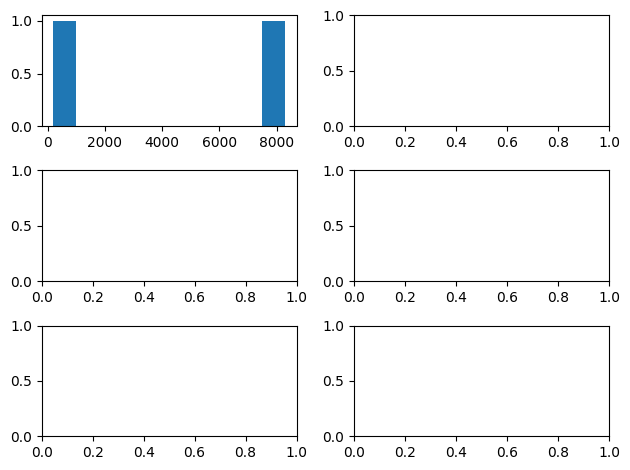

In [94]:
# VIP 상관관계 분석
print(len(train_df[train_df['VIP']==True]), len(transport_df[transport_df['VIP'] == True]))
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['VIP'].value_counts())


plt.tight_layout()
plt.show()